# A toy example for modeling complex drug-protein interactions using RAF kinases and RAF inhibitors

Here, we provide the step-by-step construction code for a toy example to model complex drug-protein interactions using PySB with energy formulation (through support for eBNG). This example describes RAF kinases as the drug target and RAF inhibitors as the drug. To run this code you'll need to have Pysb with BNG installed, please follow instructions at: http://pysb.org/ .

### Manual definition of the biochemical reaction system

To start, we import all required Pysb classes and instantiate the model:

In [1]:
from pysb import Model, Monomer, Parameter, Expression,  Rule, Observable, Initial, Annotation, EnergyPattern, ANY
from pysb.bng import generate_equations
from pysb.export import export
from sympy import exp, log

Model();

Next, we define the two basic components of the model, RAF kinases (R) and RAF inhibitors (I): 

In [2]:
#define a monomer R that represents a RAF kinase with a binding site for RAF (r) and another for the drug (i)
Monomer('R', ['r', 'i']);   
#define a monomer I that represents a RAF inhibitor with a binding site for RAF (r) 
Monomer('I',['r']);   

We define the parameters for initializing abundance of components:

In [3]:
#define the initial conditions for R and I
Parameter('R_0',0.01);  # uM
Parameter('I_0',0.0);  # uM
Initial(R(r=None, i=None), R_0);
Initial(I(r=None), I_0);

Then, we define the kinetic parameters and thermodynamic factors: 

In [4]:
#define dissociation constant (kD), forward rate (kf) and distributionr rate (phi) for RAF dimerization
Parameter('RR_kD',10);  #uM
Parameter('RR_kf',1.0);  #/s/uM
Parameter('RR_phi',1.0); #unitless 

#define dissociation constant (kD), forward rate (kf) and distributionr rate (phi) for drug binding to RAF
Parameter('RI_kD',0.1);  #uM
Parameter('RI_kf',1.0);  #/s/uM
Parameter('RI_phi',1.0); #unitless

#define thermodynamic factors f and g
Parameter('f',1.0);  #unitless 
Parameter('g',1.0);  #unitless

We convert the kinetic parameters into corresponding energy parameters:

In [5]:
#convert kinetic parameters into energies for RAF dimerization
Expression('Gf_RR', log(RR_kD)); #unitless 
Expression('Ea0_RR',-RR_phi*log(RR_kD)-log(RR_kf)); #unitless 

#convert kinetic parameters into energies for drug binding to RAF
Expression('Gf_RI', log(RI_kD)); #unitless 
Expression('Ea0_RI',-RI_phi*log(RI_kD)-log(RI_kf)); #unitless 

#convert thermodynamic factors into energies
Expression('Gf_f',log(f)); #unitless 
Expression('Gf_g',log(g)); #unitless 

We define the energy patterns to assign energies within biochemical species:

In [6]:
# define energy in bond between R and R
EnergyPattern('ep_RR',R(r=1)%R(r=1),Gf_RR);

# define energy in bond between R and I
EnergyPattern('ep_RI',R(i=1)%I(r=1),Gf_RI);

# define additional energy in bond betwee RAF dimer and a single drug molecule
Expression('Gf_RRI',Gf_f);
EnergyPattern('ep_RRI',R(r=1,i=None)%R(r=1,i=2)%I(r=2), Gf_RRI);

# define additional energy in bond betwee RAF dimer and two drug molecules
Expression('Gf_IRRI', Gf_f + Gf_g);
EnergyPattern('ep_IRRI',I(r=2)%R(r=1,i=2)%R(r=1,i=3)%I(r=3), Gf_IRRI);

We define observables that are used later to visualize results from model simulations: 

In [7]:
# define observable for total RAF and total drug
Observable('Rtot_obs', R());
Observable('Itot_obs', I());

#define an observable that counts the amount of active RAF when RAF represents a BRAF V600E/K mutant
#that is active independently of dimerization stauts (i.e. both as a monomer or as a dimer) as long as it is not drug bound
Observable('R_BRAFmut_active_obs', R(i=None));

#define an observable that counts the amount of active RAF when RAF here represents a wild type version of BRAF or CRAF
#that is active only when dimerized and not drug bound
Observable('R_RAFwt_active_obs', R(r=1,i=None)%R(r=1));

# define observable for drug unbound RAF monomer
Observable('R_obs', R(i=None,r=None));

# define observable for RAF dimer unbound by drug
Observable('RR_obs', R(r=1,i=None)%R(r=1,i=None));

# define observable for RAF dimer bound by single drug
Observable('RRI_obs', R(r=1,i=None)%R(r=1,i=2)%I(r=2));

# define observable for RAF dimer bound by double drug
Observable('IRRI_obs', I(r=2)%R(r=1,i=2)%R(r=1,i=3)%I(r=3));

As the last step in the model construction, we define the reactions for RAF dimerization and drug binding: 

In [8]:
#define RAF dimerization reaction
Rule('RR', R(r=None)+R(r=None) | R(r=1)%R(r=1) , RR_phi, Ea0_RR, energy=True);

#define drug binding to RAF reaction
Rule('RI', R(i=None)+I(r=None) | R(i=1)%I(r=1) , RI_phi, Ea0_RI, energy=True);

### Automatic generation of the kinetic model

We generate the kinetic model by passing the information build via PySB to BNG, parse the returned reaction network and list the properties of the resulting kinetic model: 

In [9]:
# generate the model equations
generate_equations(model)

# print model infomration
print ('RAF-RAFi model information')
print ('Species:',len(model.species))
print ('Parameters:',len(model.parameters)+len(model.initial_conditions))
print ('Expressions:',len(model.expressions))
print ('Observables:', len(model.observables))
ntotr=len(model.rules);
nenergy=len([r for r in model.rules if r.energy]);
print ('Total Rules:', ntotr)
print ('Energy Rules:', nenergy)
print('Non-energy Rules:', ntotr-nenergy)
print('Energy Patterns:', len(model.energypatterns))
print('Reactions:',len(model.reactions))

RAF-RAFi model information
Species: 6
Parameters: 12
Expressions: 20
Observables: 8
Total Rules: 2
Energy Rules: 2
Non-energy Rules: 0
Energy Patterns: 4
Reactions: 12


We plot the automatically generated equation rates to check that thermodynamic factors indeed control cooperative reaction rates:

In [10]:
# to appear

### Model simulations

We use the generated model to simulate the response of RAF kinases to three classes of RAF inhibitors: 1st generation (e.g. Vemurafenib, Dabrafenib and Encorafenib), paradox breakers (e.g. PLX8349) and panRAF (e.g. LY3009120, AZ628) inhibitors. We compare the results to a hypothetical RAF inhibitor that has no cooperative effect with RAF dimerization, which we term a "independent" RAF inhibitor. We observe the effect of the drugs in situations with low and high propensity for RAF dimerization (controlled by setting the Kd values of the RAF dimerization reactions) to study the effect that the drugs have in absence or presence of the dimerization status of RAFs, for example as induced by Ras-GTP signal that induces RAF dimerization. First, we set up the model with the right parameter values and with a drug-dose response concentrations of the RAF inhibitor: 

In [11]:
#import ODE simulator
from pysb.simulator import ScipyOdeSimulator
#import various utility packages
import numpy as np

#set the dilution range for the RAF inhibitor
RAFi_dil=np.logspace(-4, 1, 20, base=10.0); #uM
#set the values of f and g to model RAF inhibitors with different complex drug-protein interactions
#independent: f=1, g=1 , 1st generation: f= 0.001, g=1000; paradox breaker: f= 1.0, g=1000; panRAF: f= 0.001, g=1
ff=[1.0, 0.001, 1.0, 0.001];
gg=[1.0, 1000, 1000, 1];
fgtitle=['independent', '1st_gen', 'paradox_breaker', 'panRAF'];
#set the Kd values to use for baseline RAF dimerization to simulate Ras-GTP signaling that induced dimerization
RR_kDs_exp=np.linspace(-5, 5, 21)[::-1];
RR_kDs=10**RR_kDs_exp;

#set the time of simulation
t_start = 0.0; #
t_end = 60.0 * 60; # seconds
tspan = np.linspace(t_start, t_end);

#set up the ODE simulator for the model
sim = ScipyOdeSimulator(model, atol=1E-50);

Compiling C:\Users\lg166\.cython\inline\_cython_inline_551f75fd7dde7a7ad69d2d67551c8971.pyx because it changed.
[1/1] Cythonizing C:\Users\lg166\.cython\inline\_cython_inline_551f75fd7dde7a7ad69d2d67551c8971.pyx


Then, we perform multiple simulations of the systems at each defined combination of thermodynamic parameters (f,g), RAF inhibitor concentration (RAFi) and RAF dimerization baseline (RR_Kd): 

<IPython.core.display.Javascript object>


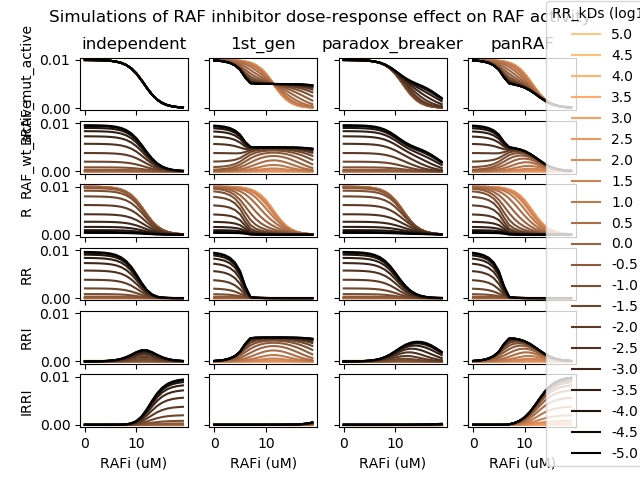

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

#define observables to plot
plt_obs=['R_BRAFmut_active_obs', 'R_RAFwt_active_obs', 'R_obs', 'RR_obs', 'RRI_obs', 'IRRI_obs'];
plot_obs_names=['BRAF_mut_active', 'RAF_wt_active', 'R', 'RR', 'RRI', 'IRRI'];

#define figure 
fig, ax = plt.subplots(len(plt_obs),len(gg), sharey=True);
fig.suptitle("Simulations of RAF inhibitor dose-response effect on RAF activity");  

#define plot colors
cmap=plt.get_cmap('copper');
col=cmap(np.linspace(0.0, 1.0, len(RR_kDs_exp)))[::-1];

#simulate the different parameter combinations
ss_v = np.empty([len(RAFi_dil), len(plt_obs)]);
for i in range (len(ff)):
    for j in range(len(RR_kDs)):
        for k in range(len(RAFi_dil)):
            #run simulation with modified parameters
            res = sim.run(tspan=tspan, param_values={'f': ff[i] ,'g': gg[i], 'RR_kD': RR_kDs[j], 'I_0': RAFi_dil[k]})
            #extract end of simulation for each osbervables from the dataframe of simulation results
            for z in range(len(plt_obs)):
                #ss_v[i,j,k,z]=res.observables[plt_obs[z]][-1];
                ss_v[k,z]=res.observables[plt_obs[z]][-1];
        #plot the results for a given RR_KD and f,g combination
        for z in range(len(plt_obs)):
             #plot simualtion 
             h=ax[z,i].plot(ss_v[:,z], color = col[j,:]);            
             #set axis names
             if (i==0):
                ax[z,i].set_ylabel(plot_obs_names[z]);
             if (z==0):
                ax[z,i].title.set_text(fgtitle[i]);
             if (z==(len(plt_obs)-1)):
                ax[z,i].set_xlabel('RAFi (uM)');
#add legend
fig.legend(ax, labels= list(map(str, RR_kDs_exp)) , bbox_to_anchor=(1.04,1), loc="upper right", borderaxespad=0.1, title="RR_kDs (log10)");

The resulting simulations show the expected behavior of these four different RAF inhibitor classes on both the situation of RAF representing a BRAF V600E/K mutant or wild-type BRAF/CRAF:

* In the first column, the independent RAF inhibitor does not change its affinity to RAF depending on dimerization status, nor does it influence dimerization itself. As such, BRAF mutant inhibition is effective (first row) and independent on RAF dimerization from upstream signal (RR_kD). Similarly, the effect on a wild-type RAF context is a straightforward dose-dependent inhibition of RAF signaling that depends on the baseline RAF dimerization due to upstream signal (RR_kD) (second row). Note that there is no difference in the potency of the drug between the oncogenic BRAF mutant and RAF wild-type signal (compare first and second panel). 


* In the second column, the 1st generation RAF inhibitor efficiently inhibits RAF signaling from monomers (light colored line), but RAF dimeric signal generated by either upstream RAF dimerization (RR_Kd) or by the propensity of the drug to cause RAF dimerization (f parameter less than one) creates a resistance mechanism (seen as the increased amount of active RAFs in the first row when comparing light and dark colored lines). This resistance mechanism is due to the low affinity of the drug for the second RAF protomer in a RAF dimer (g parameter more than one), as seen by the rise of single drug-bound RAF dimers in the 5th row. In addition, wild-type RAF signaling is potentiated by the drug, as can be seen by the increase in active RAF signaling (2nd row) that is drug-dependent at otherwise low levels of upstream RAF dimerization. This effect, known to induced toxicity through inducing proliferation of other malignant cells by drug-induced MAPK activation, is also known as paradoxical activation. 


* In the third column, a paradox breaker RAF inhibitor is seen reducing the extend of resistance due to RAF dimerization (1st row) in the BRAF-mutant case and of RAF dimerization potentiation by paradoxical activation (2nd row), since the drug binding does not induce dimerization (f is equal to one) and thus does not synergize with the upstream RAF dimerization signal. This can be seen as the reduced amount of single drug-bound RAF dimers in the 5th row. 


* In the last column, a panRAF inhibitor is seen eventually binding both protomers in RAF dimers (g is equal to one), thus completely ablating any resistance mechanism caused by RAF dimerization. This can be seen as the eventual reduction in the amount of single drug-bound RAF dimers in the 5th row and dose-dependent rise of double drug-bound RAF dimers in the 6th column. Note that in this case, pan RAF inhibitors have the same potency on the RAF-mutant and wild-type signal again (compare potencies on 1st and 2nd rows).


Thus, the model automatically generated using energy-based rule-based modelling properly describes and simulates the complex drug-protein interactions that are supposed to govern drug efficacy and toxicity in this simplified scenario for RAF kinases and RAF inhibitors.

